### First, we create a notebook with autoreload with appropriate imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

from pathlib import Path
import shutil
import numpy as np

import spikeinterface.full as si
import probeinterface

In [3]:
base_folder = Path("/home/samuel/DataSpikeSorting/WIRED_SI_tutos/")

### We set the number of jobs globally for spikeinterface

In [4]:
si.set_global_job_kwargs(n_jobs=-1, chunk_duration="1s", progress_bar=True)

### Then we focus on a particular dataset

In [5]:
probe_type = "AdTech"
subject_id = "sub-002"
session_id = "sess-001"

In [6]:
neuralynx_folder = base_folder / "Neuralynx" / probe_type / subject_id / session_id / "ieeg"
print(neuralynx_folder)

binary_folder = base_folder / "Binary" / probe_type / subject_id / session_id / "ieeg"
binary_folder.parent.mkdir(exist_ok=True, parents=True)
print(binary_folder)

(base_folder / "sortings").mkdir(exist_ok=True, parents=True)

/home/samuel/DataSpikeSorting/WIRED_SI_tutos/Neuralynx/AdTech/sub-002/sess-001/ieeg
/home/samuel/DataSpikeSorting/WIRED_SI_tutos/Binary/AdTech/sub-002/sess-001/ieeg


### We can load the data from neuralynx format and save it to binary

In [7]:
if binary_folder.exists():
    # already converted
    raw_recording =si.load_extractor(binary_folder)
else:
    raw_recording = si.read_neuralynx(neuralynx_folder)
    print(raw_recording)
    raw_recording = si.concatenate_recordings([raw_recording])
    print(raw_recording)
    raw_recording = raw_recording.save(folder=binary_folder)


In [8]:
print(raw_recording)

BinaryFolderRecording: 16 channels - 32.8kHz - 1 segments - 235,930,370 samples 
                       7,200.02s (2.00 hours) - int16 dtype - 7.03 GiB


### We need to create the probes, and attach them to the recordings

In [12]:
probe = probeinterface.generate_multi_columns_probe(num_columns=4, num_contact_per_column=4)
probe.set_device_channel_indices(np.arange(raw_recording.get_num_channels()))
probe

Probe - 16ch - 1shanks

In [14]:
probe.to_dataframe()

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0.0,0.0,circle,6.0,,0
1,0.0,20.0,circle,6.0,,1
2,0.0,40.0,circle,6.0,,2
3,0.0,60.0,circle,6.0,,3
4,20.0,0.0,circle,6.0,,4
5,20.0,20.0,circle,6.0,,5
6,20.0,40.0,circle,6.0,,6
7,20.0,60.0,circle,6.0,,7
8,40.0,0.0,circle,6.0,,8
9,40.0,20.0,circle,6.0,,9


In [15]:
raw_recording = raw_recording.set_probe(probe)
print(raw_recording)

BinaryFolderRecording: 16 channels - 32.8kHz - 1 segments - 235,930,370 samples 
                       7,200.02s (2.00 hours) - int16 dtype - 7.03 GiB


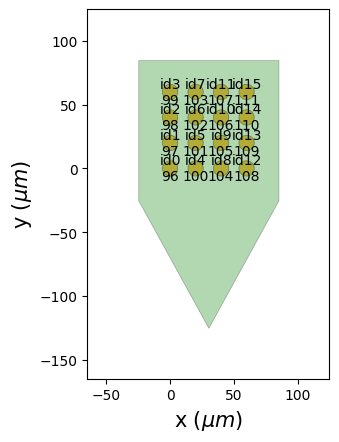

In [16]:
si.plot_probe_map(raw_recording, with_channel_ids=True, with_contact_id=True)

## explore raw traces

two way:
  * inside jupyter with `backend="ipywidgets"` : slow but enable remote visualization
  * using desktop app `backend="ephyviewer"` (no remote vis) : faster but freeze the nojypter


In [17]:
%matplotlib widget
si.plot_traces(raw_recording, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [18]:
# this work only with local notebook!!!
%gui qt
si.plot_traces(raw_recording, backend="ephyviewer")

### We can preprocess the signals, and also extract an enveloppe to remove/identify artefacts

In [19]:
recording_f = si.bandpass_filter(raw_recording, freq_min=300.0, freq_max=8000.0, dtype='float32')
recording_preprocess = si.common_reference(recording_f)
recording_preprocess


CommonReferenceRecording: 16 channels - 32.8kHz - 1 segments - 235,930,370 samples 
                          7,200.02s (2.00 hours) - float32 dtype - 14.06 GiB

In [20]:
%matplotlib widget
si.plot_traces({"preprocess": recording_preprocess, "filtered_only":recording_f} , backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [21]:
%gui qt
si.plot_traces(recording_preprocess, backend="ephyviewer")

## detect and remove artifact

The preprocess signal show very high artifact.

Here a simple way to handle then:
  * create the signal envelop
  * detect period with high
  * blank period with zeros or noise


In [ ]:
from threshold_detector import detect_artefacts
## Get the enveloppe
enveloppe = si.rectify(recording_preprocess)
enveloppe = si.gaussian_filter(enveloppe, freq_min=None, freq_max=20.)
enveloppe = si.common_reference(enveloppe)
print(enveloppe)

periods = detect_artefacts(enveloppe, detect_threshold=5)
print("Artefact period", len(periods))

CommonReferenceRecording: 16 channels - 32.8kHz - 1 segments - 235,930,370 samples 
                          7,200.02s (2.00 hours) - float32 dtype - 14.06 GiB


detecting threshold crossings:   0%|          | 0/7201 [00:00<?, ?it/s]

In [22]:
recording_silenced = si.silence_periods(recording_preprocess, periods, mode='zeros')
# recording_silenced = si.silence_periods(recording_preprocess, periods, mode='noise')
recording_silenced

SilencedPeriodsRecording: 4 channels - 32.8kHz - 1 segments - 235,930,370 samples 
                          7,200.02s (2.00 hours) - float32 dtype - 3.52 GiB

In [23]:
%matplotlib widget
si.plot_traces({"silenced": recording_silenced, "with_artifact":recording_preprocess} , backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [24]:
%gui qt
si.plot_traces({"silenced": recording_silenced, "with_artifact":recording_preprocess}, backend='ephyviewer')

In [25]:
recording = recording_silenced

### Let's launch a very simple and naive sorter on the data (peak detection, feature extraction, clustering)

In [26]:

sorter_name = 'simple'
output_folder = base_folder / "sortings" / f"{probe_type} {subject_id} {session_id} {sorter_name}"
print(output_folder)
if output_folder.exists():
    shutil.rmtree(output_folder)


sorting = si.run_sorter(sorter_name, recording, verbose=True, 
                          output_folder=output_folder,
                          apply_preprocessing=False,
                          detection= {"peak_sign": "neg",  "detect_threshold": 6.0, "radius_um": 150.},
                          clustering={"method" : "hdbscan"},
                          # clustering={"method" : "kmeans", "n_init" : "auto", "n_clusters": 3},
                          # clustering={"method" : "mean_shift"},
                          )
sorting

/home/samuel/DataSpikeSorting/WIRED_SI_tutos/sortings/AdTech sub-002 sess-001 simple
noise_levels [22.767258 21.0064   22.557152 21.929193]
detect peaks using locally_exclusive with n_jobs = 4 and chunk_size = 32768


detect peaks using locally_exclusive:   0%|          | 0/7201 [00:00<?, ?it/s]

We found 104185 peaks in total
extract waveforms shared_memory mono buffer with n_jobs = 4 and chunk_size = 32768


extract waveforms shared_memory mono buffer:   0%|          | 0/7201 [00:00<?, ?it/s]

extracting features with n_jobs = 4 and chunk_size = 32768


extracting features:   0%|          | 0/7201 [00:00<?, ?it/s]

simple run time 99.61s


NumpyFolderSorting: 9 units - 1 segments - 32.8kHz

### We can explore the features that have been found, with the assigned labels

In [29]:
features = np.load(output_folder / "sorter_output" / "features" / "features_tsvd.npy")
features_flat = features.reshape(len(features), -1)
labels = np.load(output_folder / "sorter_output" / "features" / "peak_labels.npy")
print(features.shape, features_flat.shape, labels.shape)

(104185, 3, 4) (104185, 12) (104185,)


### We can do a 2D projections from a High Dimensional space with UMAP

In [30]:
import umap
mapper = umap.UMAP().fit(features_flat[::50])

/home/samuel/.virtualenvs/py3.11/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


<Axes: >

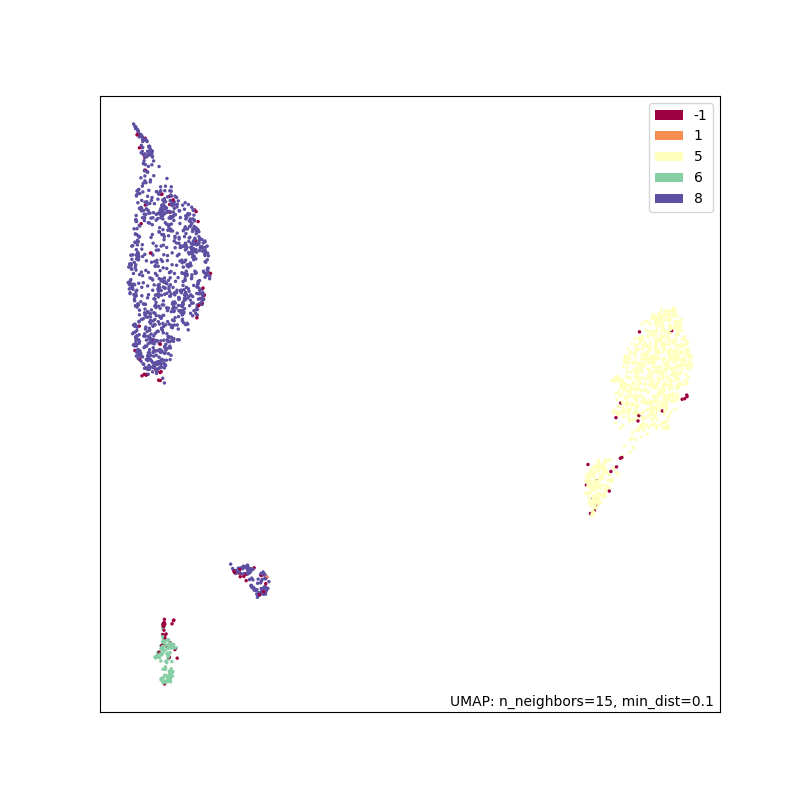

In [31]:
import umap.plot
umap.plot.points(mapper, labels=labels[::50])

## Run SortingAnalzer

In [32]:
analyzer = si.create_sorting_analyzer(sorting, recording_preprocess, format="memory")
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels",
                  "spike_amplitudes", "template_similarity"])
analyzer.compute("unit_locations", method="monopolar_triangulation")
analyzer.compute("correlograms", window_ms=50., bin_ms=1.)
analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True)
analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate", "rp_violation"])
print(analyzer)


estimate_sparsity:   0%|          | 0/7201 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/7201 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/7201 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/9 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/9 [00:00<?, ?it/s]

SortingAnalyzer: 4 channels - 9 units - 1 segments - memory - sparse - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, template_similarity, unit_locations, correlograms, principal_components, quality_metrics


In [33]:
anlyzer_folder = base_folder / "sortings" / f"Analyzer {probe_type} {subject_id} {session_id} {sorter_name}"
if anlyzer_folder.exists():
    shutil.rmtree(anlyzer_folder)
analyzer = analyzer.save_as(format="binary_folder", folder=anlyzer_folder)
print(analyzer)

SortingAnalyzer: 4 channels - 9 units - 1 segments - binary_folder - sparse - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, template_similarity, unit_locations, correlograms, principal_components, quality_metrics


In [35]:
%gui qt
si.plot_sorting_summary(analyzer, backend='spikeinterface_gui')

### Let's launch more advanced sorters using template mathcing : spykingcircus2

In [ ]:

sorter_name = 'spykingcircus2'
output_folder = base_folder / "sortings" / f"{probe_type} {subject_id} {session_id} {sorter_name}"
print(output_folder)

if output_folder.exists():
    shutil.rmtree(output_folder)

sorting = si.run_sorter(sorter_name, recording, verbose=True, 
                          output_folder=output_folder,
                          apply_preprocessing=False, 
                          detection= {"peak_sign": "neg",  "detect_threshold": 5.0,},
                          )
sorting

/home/samuel/DataSpikeSorting/WIRED_SI_tutos/sortings/AdTech sub-002 sess-001 spykingcircus2
detect peaks using locally_exclusive with n_jobs = 3 and chunk_size = 32768


detect peaks using locally_exclusive:   0%|          | 0/7201 [00:00<?, ?it/s]

We found 458498 peaks in total
We kept 100000 peaks for clustering
extracting features with n_jobs = 3 and chunk_size = 32768


extracting features:   0%|          | 0/7201 [00:00<?, ?it/s]

estimate_templates with n_jobs = 3 and chunk_size = 32768


estimate_templates:   0%|          | 0/7201 [00:00<?, ?it/s]

/home/samuel/Documents/SpikeInterface/spikeinterface/src/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


We found 95 raw clusters, starting to clean with matching...
We kept 84 non-duplicated clusters...
estimate_templates with n_jobs = 3 and chunk_size = 32768


estimate_templates:   0%|          | 0/7201 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 3 and chunk_size = 3276


find spikes (circus-omp-svd):   0%|          | 0/72018 [00:00<?, ?it/s]

In [ ]:
analyzer = si.create_sorting_analyzer(sorting, recording_preprocess, format="memory")
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels",
                  "isi_histograms", "spike_amplitudes", "template_similarity"])
analyzer.compute("unit_locations", method="grid_convolution")
analyzer.compute("correlograms", window_ms=50., bin_ms=1.)
analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True)
analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate", "rp_violation"])
print(analyzer)

In [ ]:
anlyzer_folder = base_folder / "sortings" / f"Analyzer {probe_type} {subject_id} {session_id} {sorter_name}"
if anlyzer_folder.exists():
    shutil.rmtree(anlyzer_folder)
analyzer = analyzer.save_as(format="binary_folder", folder=anlyzer_folder)
print(analyzer)

In [47]:
%gui qt
si.plot_sorting_summary(analyzer, backend='spikeinterface_gui')